# Predicting video games sales

## Introduction
Based on the code of Maksim Klimentyev, available at https://www.kaggle.com/maxkliment/video-games-predicting-global-sales  

## Preparations and EDA
Importing data science packages and checking what files we have in the dataset

In [107]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'Battlefield 1', 'Blocos de Anotações do OneNote', 'ComboKey', 'desktop.ini', 'kernel.ipynb', 'Meus Vídeos', 'Minhas fontes de dados', 'Minhas Imagens', 'Minhas Músicas', 'Modelos Personalizados do Office', 'My Digital Editions', 'My Kindle Content', 'Video_Games_Sales_as_at_22_Dec_2016.csv', 'Visual Studio 2017']


Setting visualisation parameters

In [110]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

# Set default font size and facecolor
plt.rcParams["font.size"] = 24
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
figsize(12, 10)

# Seaborn for visualization
import seaborn as sns

Reading and exploring data

In [3]:
data = pd.read_csv("./Video_Games_Sales_as_at_22_Dec_2016.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


We have ~17k games, but some of the data is missing. For instance, we see that only around half of all games has a critic score. This might be a problem for our prediction model, as I was thinking that critic score will be one of the main features. But we will come back to it later. We also see that the User_Score column has type object instead of float (like Critic_Score). It means that there are non-numeric values and we'll have to get rid of them.

Here I am doing 3 things:
1. Renaming columns for ease of use
2. Droping games without a year of release or genre
3. Creating a new column for age of the game

In [4]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]
data.describe(include="all")

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age
count,16448,16448,16448.000000,16448,16416,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000,7983.000000,7983.000000,9840,7463.000000,9907,9769,16448.000000
unique,11429,31,NaN,12,579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,NaN,1680,8,NaN
top,Need for Speed: Most Wanted,PS2,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tbd,NaN,Ubisoft,E,NaN
freq,12,2127,NaN,3308,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2377,NaN,201,3922,NaN
mean,NaN,NaN,2006.488996,NaN,NaN,0.263965,0.145895,0.078472,0.047583,0.53617,68.994363,26.441313,NaN,163.015141,NaN,NaN,11.511004
std,NaN,NaN,5.877470,NaN,NaN,0.818286,0.506660,0.311064,0.187984,1.55846,13.920060,19.008136,NaN,563.863327,NaN,NaN,5.877470
min,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.01000,13.000000,3.000000,NaN,4.000000,NaN,NaN,-2.000000
25%,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.06000,60.000000,12.000000,NaN,10.000000,NaN,NaN,8.000000
50%,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.17000,71.000000,22.000000,NaN,24.000000,NaN,NaN,11.000000
75%,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.47000,79.000000,36.000000,NaN,81.000000,NaN,NaN,15.000000


2 things to see in the table above:
1. The top value in User_Score column is "tbd" which we will mark as NaN.
2. There are serious outliers in sales columns (Global, EU, NA, JP, Other) and User_Count column.

Now let's do some visualisation of the data.

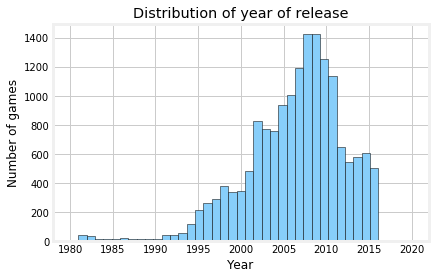

In [6]:
# Histogram plot of Year of release
num_years = data["Year"].max() - data["Year"].min() + 1
plt.hist(data["Year"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

In [23]:
#Frequency table of platforms
num_platforms = pd.crosstab(index=data["Platform"], columns="Total")
num_platforms["Frequência (%)"] = round((num_platforms/num_platforms.sum()) * 100, 2)
num_platforms.to_clipboard()
num_platforms

In [27]:
#Frequency table of genre
num_genres = pd.crosstab(index=data["Genre"], columns="Total")
num_genres["Frequência (%)"] = round((num_genres/num_genres.sum()) * 100, 2)
num_genres.to_clipboard()
num_genres

col_0,Total,Frequência (%)
Genre,,
Action,3308,20.11
Adventure,1293,7.86
Fighting,837,5.09
Misc,1721,10.46
Platform,878,5.34
Puzzle,569,3.46
Racing,1226,7.45
Role-Playing,1483,9.02
Shooter,1296,7.88


In [34]:
#Frequency table of Publisher
num_publishers = pd.crosstab(index=data["Publisher"], columns="Total")
num_publishers["Frequência (%)"] = round((num_publishers/num_publishers.sum()) * 100, 2)
num_publishers = num_publishers.sort_values(by="Total", ascending=False)
num_publishers.head(10).to_clipboard()
num_publishers.head(10)


col_0,Total,Frequência (%)
Publisher,,
Electronic Arts,1344,8.19
Activision,976,5.95
Namco Bandai Games,935,5.70
Ubisoft,930,5.67
Konami Digital Entertainment,825,5.03
THQ,712,4.34
Nintendo,700,4.26
Sony Computer Entertainment,686,4.18
Sega,631,3.84


In [36]:
#Frequency table of Developer
num_developers = pd.crosstab(index=data["Developer"], columns="Total")
num_developers["Frequência (%)"] = round((num_developers/num_developers.sum()) * 100, 2)
num_developers = num_developers.sort_values(by="Total", ascending=False)
num_developers.head(10).to_clipboard()
num_developers.head(10)

col_0,Total,Frequência (%)
Developer,,
Ubisoft,201,2.03
EA Sports,169,1.71
EA Canada,164,1.66
Konami,158,1.59
Capcom,137,1.38
EA Tiburon,104,1.05
Electronic Arts,101,1.02
Ubisoft Montreal,100,1.01
Visual Concepts,98,0.99


In [39]:
#Frequency table of Rating
num_ratings = pd.crosstab(index=data["Rating"], columns="Total")
num_ratings["Frequência (%)"] = round((num_ratings/num_ratings.sum()) * 100, 2)
num_ratings.sort_values(by="Total", ascending=False).to_clipboard()
num_ratings.sort_values(by="Total", ascending=False)


col_0,Total,Frequência (%)
Rating,,
E,3922,40.15
T,2905,29.74
M,1536,15.72
E10+,1393,14.26
EC,8,0.08
K-A,3,0.03
AO,1,0.01
RP,1,0.01


In [63]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) &
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
    return df_out, removed

data2, rmvd = rm_outliers(data, ["Global"])
data2["Global"].describe().to_clipboard()
data2["Global"].describe()

count    15401.000000
mean     0.289258    
std      0.346918    
min      0.010000    
25%      0.060000    
50%      0.150000    
75%      0.380000    
max      1.690000    
Name: Global, dtype: float64

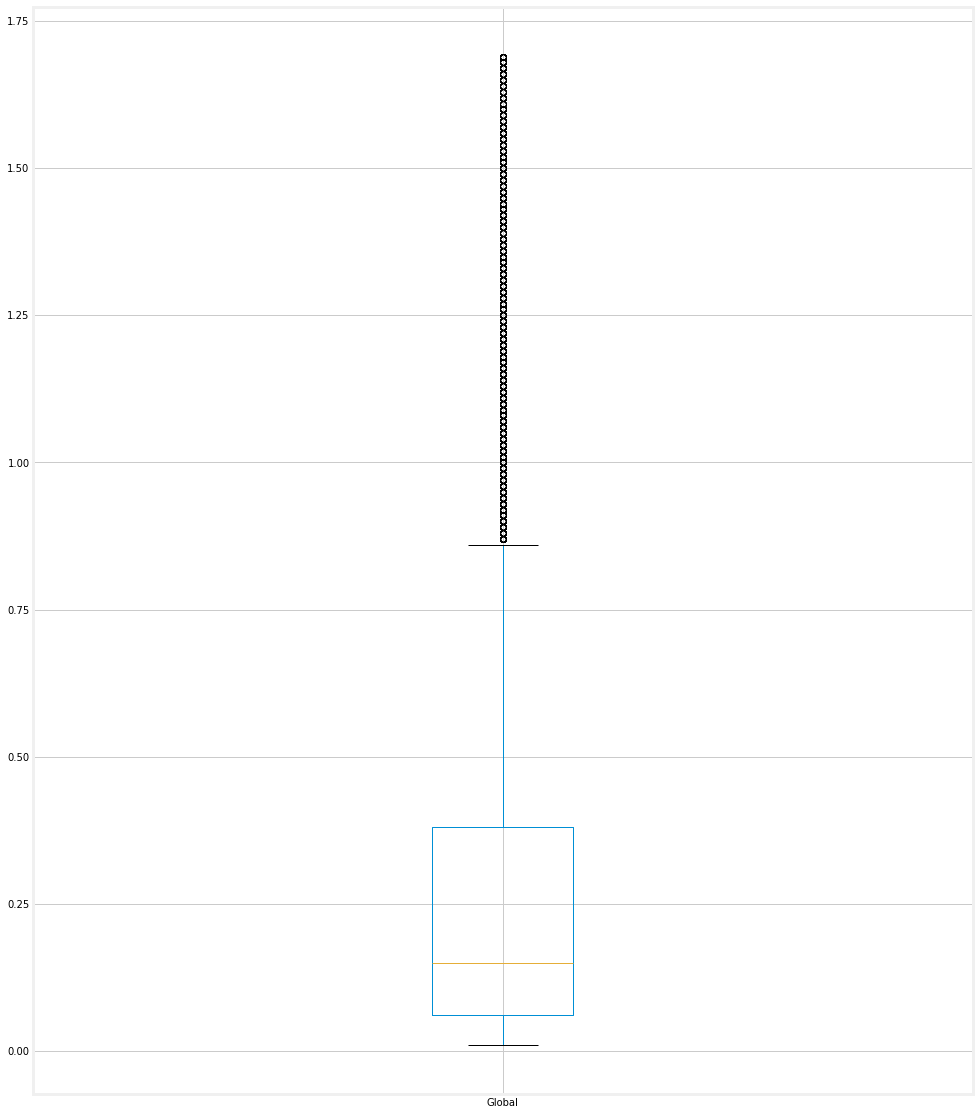

In [68]:
#Measures of Global Sales
num_global_sales = data2.boxplot(column="Global", figsize=(15, 20))
num_global_sales
plt.savefig(r"C:\Users\1765 IRON\My Tresors\Henrique's tresor\Cursos\Big Data - FIA\big-data-tcc\boxplot_globalsales.png")

In [72]:
data["Critic_Score"].describe().to_clipboard()
data["Critic_Score"].describe()

count    7983.000000
mean     68.994363  
std      13.920060  
min      13.000000  
25%      60.000000  
50%      71.000000  
75%      79.000000  
max      98.000000  
Name: Critic_Score, dtype: float64

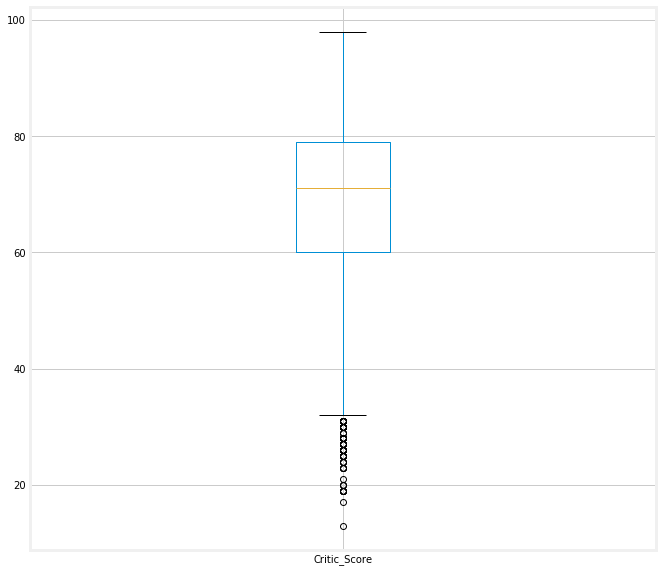

In [76]:
#Measures of Critic Score
num_ratings = data.boxplot(column="Critic_Score", figsize=(10, 10))
num_ratings
plt.savefig(r"C:\Users\1765 IRON\My Tresors\Henrique's tresor\Cursos\Big Data - FIA\big-data-tcc\boxplot_criticscore.png")

In [74]:
# Replacing "tbd" values with np.nan and transforming column to float type
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)
data["User_Score"].describe().to_clipboard()
data["User_Score"].describe()

count    7463.000000
mean     7.126330   
std      1.499447   
min      0.000000   
25%      6.400000   
50%      7.500000   
75%      8.200000   
max      9.700000   
Name: User_Score, dtype: float64

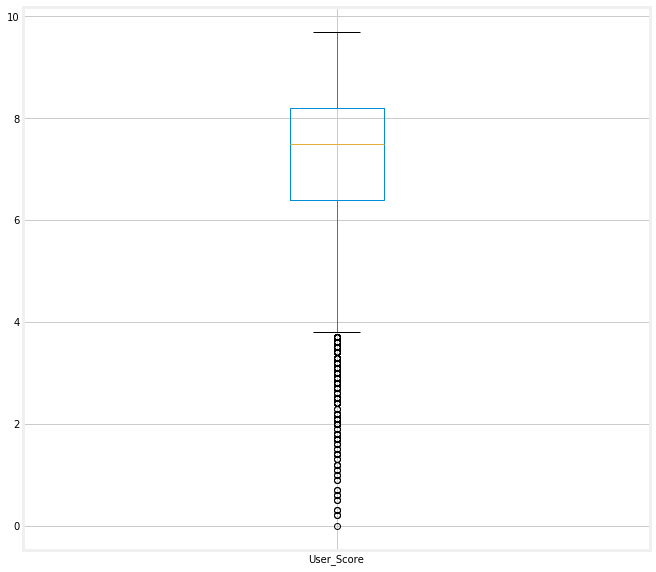

In [77]:
#Measures of User Score
num_ratings = data.boxplot(column="User_Score", figsize=(10, 10))
num_ratings
plt.savefig(r"C:\Users\1765 IRON\My Tresors\Henrique's tresor\Cursos\Big Data - FIA\big-data-tcc\boxplot_userscore.png")

In [ ]:
#Measures of Critic Score
num_ratings = data.boxplot(column="Critic_Score", figsize=(10, 10))
num_ratings
plt.savefig(r"C:\Users\1765 IRON\My Tresors\Henrique's tresor\Cursos\Big Data - FIA\big-data-tcc\boxplot_criticscore.png")

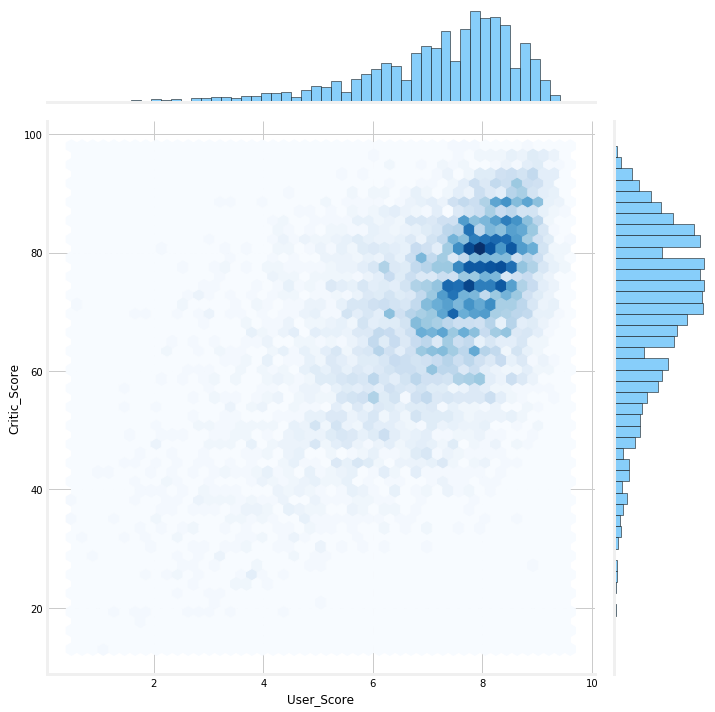

In [85]:
# Replacing "tbd" values with np.nan and transforming column to float type
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)

g = sns.jointplot(x="User_Score", y="Critic_Score", data=data, cmap="Blues", kind="hex", 
                  height=10, marginal_kws={"hist_kws" : {"edgecolor": "black", "color": "lightskyblue", "alpha": 1}}, 
                  annot_kws={"loc": 4, "fontsize": 18});
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False);

Most of the games have a pretty good score, 7+ (or 70+ for critic score). We also see a Pearson's correlation coefficient of 0.58 between critic and user scores. 

Next I want to see how many values there are missing in each column. I am using a function I found in one of [William Koehrsen](https://towardsdatascience.com/@williamkoehrsen) blogs on Medium, which he himself took from a discussion on stackoverflow. 

In [87]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [88]:
missing_values_table(data)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
User_Score,8985,54.6
User_Count,8985,54.6
Critic_Score,8465,51.5
Critic_Count,8465,51.5
Rating,6679,40.6
Developer,6541,39.8
Publisher,32,0.2


More than 50% of user and critic scores are missing. That's a lot! Usually you should drop features with too many missing values, but here I think that scores are invaluable for sales prediction, so we'll have to find a way around the problem.

As I mentioned above, there are outliers in sales columns. They might be usefull for training as they indicate bestseller games, but for now I am going to remove them and maybe add them later.  
  
  Again, I took this very useful function from William Koehrsen. Here an outlier is defined as a value greater than (or lesser than) third quartile (first quartile) plus 3 interquartile ranges (minus 3 interqurtile ranges). 

In [89]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) &
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
    return df_out, removed

In [90]:
data, rmvd = rm_outliers(data, ["Global"])
data.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,7286.000000,7286.000000,6747.000000,6747.000000,15401.000000
mean,2006.592624,0.144688,0.072628,0.047301,0.024357,0.289258,67.779028,24.518117,7.079976,111.325033,11.407376
std,5.758078,0.210709,0.131408,0.130786,0.050152,0.346918,13.612120,17.194878,1.511031,406.635191,5.758078
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000,-2.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,59.000000,11.000000,6.300000,9.000000,8.000000
50%,2007.000000,0.070000,0.020000,0.000000,0.010000,0.150000,70.000000,20.000000,7.400000,21.000000,11.000000
75%,2010.000000,0.190000,0.080000,0.030000,0.030000,0.380000,78.000000,34.000000,8.200000,61.000000,15.000000
max,2020.000000,1.670000,1.580000,1.650000,1.180000,1.690000,98.000000,106.000000,9.700000,10665.000000,38.000000


I am going to build 2 models: a basic one and a more complicated. In a basic model i will drop games without a score (critic or user) and train it on the remaining data. I will also do minimum feature engineering or feature selection. After I am finished with the basic model, I am going to come back to the full dataset and try to impute missing values and create new features.  
  
  Let's investigate differences between the groups (with and without score). 

In [91]:
data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()

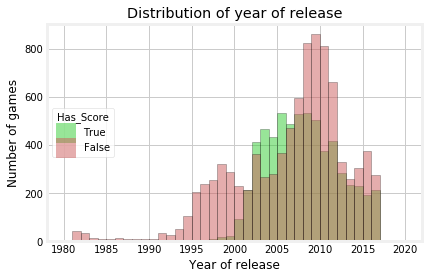

In [92]:
from matplotlib.lines import Line2D
plt.hist(data[data["Has_Score"]==True]["Year"], color="limegreen", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.hist(data[data["Has_Score"]==False]["Year"], color="indianred", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.legend(handles=[Line2D([0], [0], color="limegreen", lw=20, label="True", alpha=0.5),
                    Line2D([0], [0], color="indianred", lw=20, label="False", alpha=0.5)],
           title="Has_Score", loc=6);

We see that games with score are more evenly spread between 2000 and 2015, while there is a peak at 2010 for games without score. Probably there were so many games published in 2010 that a lot of them remained unnoticed by the community.  
  
  Another difference I noticed is in a range 1995-2000. Very few games from that period have scores, while the total number of games is quite significant. I think videogames were only starting to rise in popularity, but there was no dedicated platform (like Steam now) or specialised magazine to review games. 

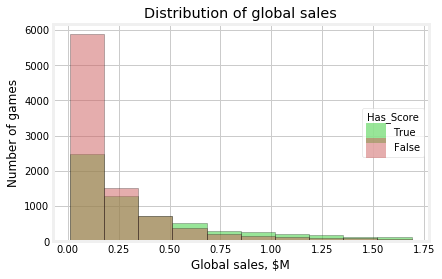

In [93]:
plt.hist(data[data["Has_Score"]==True]["Global"], color="limegreen", alpha=0.5, 
         edgecolor="black")
plt.hist(data[data["Has_Score"]==False]["Global"], color="indianred", alpha=0.5, 
         edgecolor="black")
plt.title("Distribution of global sales")
plt.xlabel("Global sales, $M")
plt.ylabel("Number of games")
plt.legend(handles=[Line2D([0], [0], color="limegreen", lw=20, label="True", alpha=0.5),
                    Line2D([0], [0], color="indianred", lw=20, label="False", alpha=0.5)],
           title="Has_Score", loc=7);

Games without score tend to have less global sales.

I want to see in what region games were more popular, based on sales.

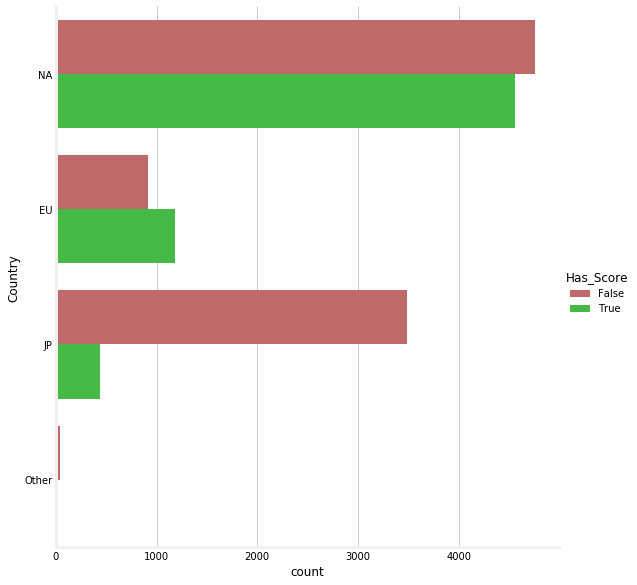

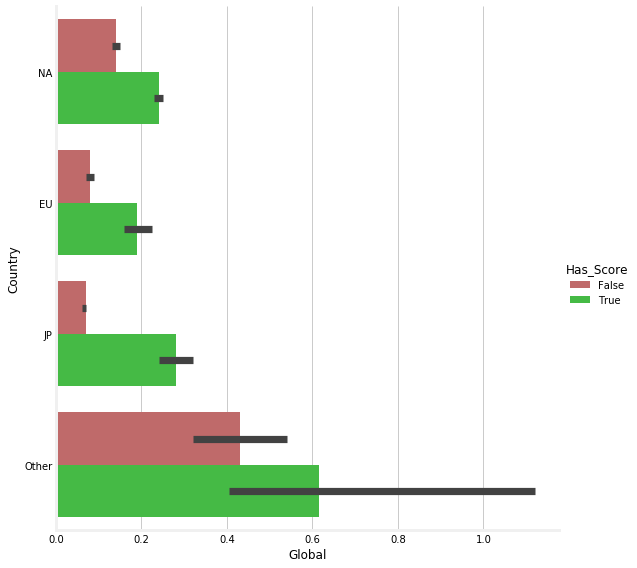

In [94]:
data["Country"] = data[["NA", "EU", "JP", "Other"]].idxmax(1, skipna=True)
palette = {True: "limegreen", False: "indianred"}
sns.catplot(y="Country", hue="Has_Score", data=data, height=8, kind="count", palette=palette)
sns.catplot(y="Country", x="Global", hue="Has_Score", data=data, height=8, kind="bar", palette=palette,
               estimator=lambda x: np.median(x));

While EU and NA have approximately the same number of scored and not scored games, situation is absolutely different for Japan. Majority of games, that were more popular in Japan than in other regions, does not have a user or critic score. Mean global sales is less for games without score, which confirmes what we saw from the histogram above.

## Basic model

For my basic model I am going to drop games that don't have a user score, critic score or rating. 

In [100]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating", "Developer", "Publisher"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000,6136.000000
mean,2007.422099,0.209798,0.112474,0.029226,0.039426,0.391157,68.979628,26.910365,7.140336,118.859518,10.577901
std,4.171287,0.231775,0.154966,0.094214,0.059874,0.389892,13.625845,17.417687,1.449408,424.470541,4.171287
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,0.100000,61.000000,13.000000,6.400000,10.000000,8.000000
50%,2007.000000,0.130000,0.050000,0.000000,0.020000,0.240000,71.000000,23.000000,7.500000,23.000000,11.000000
75%,2010.000000,0.290000,0.150000,0.000000,0.050000,0.560000,79.000000,37.000000,8.200000,66.000000,14.000000
max,2016.000000,1.670000,1.580000,1.390000,1.180000,1.690000,98.000000,106.000000,9.600000,10665.000000,33.000000


In [102]:
#Get unique platforms
data["Platform"].unique()

array(['Wii', 'PS2', 'PS3', 'PS', 'N64', 'GBA', 'DS', 'GC', 'X360', 'GB',
       'PC', '3DS', 'PSP', 'XB', 'NES', 'PS4', 'GEN', '2600', 'SNES',
       'XOne', 'WiiU', 'PSV', 'SCD', 'DC', 'SAT', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [103]:
platforms = {"Consoles Sony" : ["PS", "PS2", "PS3", "PS4"],
             "Consoles Microsoft" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Consoles Nintendo" : ["Wii", "WiiU", "NES", "SNES", "N64", "GC"],
             "Portable" : ["GB", "GBA", "DS", "3DS", "PSP", "PSV"]}

In [104]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

In [114]:
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
scored

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age,Has_Score,Country,Grouped_Platform
1059,SOCOM 3: U.S. Navy SEALs,PS2,2005,Shooter,Sony Computer Entertainment,1.22,0.34,0.04,0.10,1.69,82.0,59.0,8.8,64.0,Zipper Interactive,M,13,True,NA,Consoles Sony
1060,BioShock Infinite,PS3,2013,Shooter,Take-Two Interactive,0.72,0.65,0.04,0.28,1.69,94.0,27.0,8.5,1863.0,Irrational Games,M,5,True,NA,Consoles Sony
1065,Harry Potter and the Sorcerer's Stone,GBA,2001,Action,Electronic Arts,0.87,0.66,0.08,0.08,1.69,64.0,8.0,7.1,7.0,Griptonite Games,E,17,True,NA,Portable
1066,Dragon Ball Z: The Legacy of Goku,GBA,2002,Role-Playing,Infogrames,1.52,0.12,0.00,0.05,1.69,53.0,15.0,6.9,28.0,Webfoot Technologies,E,16,True,NA,Portable
1068,Resident Evil 4,GC,2005,Action,Capcom,0.98,0.42,0.22,0.06,1.69,96.0,82.0,9.4,767.0,Capcom,M,13,True,NA,Consoles Nintendo
1071,Need For Speed: Undercover,X360,2008,Racing,Electronic Arts,0.79,0.70,0.01,0.18,1.68,64.0,62.0,5.9,104.0,EA Vancouver,T,10,True,NA,Consoles Microsoft
1074,Sonic Colors,Wii,2010,Platform,Sega,0.92,0.60,0.01,0.15,1.68,78.0,58.0,8.5,301.0,Sonic Team,E,8,True,NA,Consoles Nintendo
1075,Saints Row 2,PS3,2008,Action,THQ,0.88,0.54,0.02,0.25,1.68,82.0,50.0,7.9,135.0,Volition Inc.,M,10,True,NA,Consoles Sony
1078,Sid Meier's Civilization V,PC,2010,Strategy,Take-Two Interactive,0.98,0.52,0.00,0.17,1.68,90.0,70.0,7.9,2280.0,Firaxis Games,E10+,8,True,NA,PC
1080,The Sims: Superstar,PC,2003,Simulation,Electronic Arts,1.67,0.00,0.00,0.00,1.68,79.0,20.0,8.2,25.0,Maxis,T,15,True,NA,PC


Feaures will consist of numeric columns (except for sales in regions) and one-hot encoded categorical columns (platform, genre, rating, developer, publisher).

In [117]:
# Select the numeric columns
numeric_subset = scored.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Age", "Critic_Count", "User_Count"])

# Select the categorical columns
categorical_subset = scored[["Grouped_Platform", "Genre", "Rating", "Developer", "Publisher"]]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

In [118]:
features.head(5)

,Year,Global,Critic_Score,User_Score,Grouped_Platform_Consoles Microsoft,Grouped_Platform_Consoles Nintendo,Grouped_Platform_Consoles Sony,Grouped_Platform_Other,Grouped_Platform_PC,Grouped_Platform_Portable,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_M,Rating_RP,Rating_T,"Developer_10tacle Studios, Fusionsphere Systems","Developer_1C, 1C Company","Developer_1C, Ino-Co, 1C Company",Developer_1C: Maddox Games,Developer_1C:Ino-Co,Developer_1st Playable Productions,Developer_2015,Developer_2D Boy,Developer_2K Australia,Developer_2K Czech,Developer_2K Games,Developer_2K Marin,Developer_2K Sports,Developer_2XL Games,Developer_369 Interactive,Developer_3DO,Developer_3G Studios,Developer_3d6 Games,Developer_49Games,Developer_4A Games,Developer_4J Studios,Developer_5000ft,Developer_505 Games,Developer_5TH Cell,Developer_5pb,Developer_7 Studios,Developer_8Monkey Labs,Developer_8ing/Raizing,Developer_989 Sports,Developer_AI,Developer_AQ Interactive,Developer_AWE Games,Developer_Access Games,Developer_Acclaim,Developer_Acclaim Studios Austin,Developer_Acclaim Studios Cheltenham,Developer_Acclaim Studios Manchester,Developer_Acquire,Developer_Activision,Developer_Activision Value,"Developer_Activision, Behaviour Interactive","Developer_Activision, FreeStyleGames","Developer_Activision, Traveller's Tales",Developer_Adrenium,Developer_Airtight Games,Developer_Akella,Developer_Aki Corp.,Developer_Alfa System,Developer_Alpha Unit,Developer_Alphadream Corporation,Developer_Altron,Developer_Amaze,Developer_Amaze Entertainment,Developer_Ambrella,"Developer_Ambrella, The Pokemon Company",Developer_Amusement Vision,Developer_Amuze,Developer_Anchor,Developer_Andamiro U.S.A. Corp.,Developer_Angel Studios,Developer_Animation Arts,Developer_ApolloSoft,Developer_Appaloosa Interactive,"Developer_Aqua Pacific, In2Games",Developer_Aqua Plus,Developer_Arc System Works,Developer_Arcade Moon,Developer_ArenaNet,Developer_Argonaut Games,Developer_Arika,Developer_Arkane Studios,Developer_Arkedo Studio,Developer_Armature Studio,"Developer_Armature Studio, comcept",Developer_Arrowhead Game Studios,Developer_Art,Developer_Artdink,Developer_ArtePiazza,Developer_Artech Studios,Developer_Artefacts Studio,Developer_Artificial Mind and Movement,"Developer_Artificial Mind and Movement, EA Redwood Shores","Developer_Artificial Mind and Movement, Polygon Magic","Developer_Artificial Studios, Immersion Software & Graphics",Developer_Artoon,Developer_Arzest,Developer_Ascaron Entertainment GmbH,"Developer_Ascaron Entertainment GmbH, Ascaron Entertainment",Developer_Asobo Studio,Developer_Aspect,Developer_Aspyr,Developer_Atari,"Developer_Atari, Slightly Mad Studios, Atari SA","Developer_Atari, Transmission Games, Atari SA",Developer_Atlus,Developer_Atlus Co.,"Developer_Atlus, Dingo Inc.",Developer_Atomic Games,Developer_Atomic Motion,Developer_Atomic Planet Entertainment,"Developer_Atomic Planet Entertainment, Mud Duck Productions",Developer_Attention To Detail,Developer_Autumn Moon,Developer_Avalanche Software,Developer_Avalanche Studios,Developer_Awesome Play Ltd.,Developer_Awesome Studios,Developer_Babylon Software,Developer_Backbone Emeryville,Developer_Backbone Entertainment,Developer_Bam Entertainment,Developer_Bandai,Developer_Bandai Namco Games,"Developer_Bandai Namco Games, Artdink","Developer_Banpresto, SoftMax",Developer_Barnhouse Effect,Developer_BattleGoat Studios,"Developer_Battlefront.com, 1C, 1C Company",Developer_Bec,Developer_BeeWorks,Developer_Beenox,Developer_Beep Industries,Developer_Behaviour Interactive,Developer_Beluga Computer,Developer_Best Way,Developer_Bethesda Game Studios,Developer_Bethesda Softworks,Developer_Beyond Games,Developer_Big Ant Studios,Developer_Big Blue Bubble Inc.,"Developer_Big Blue Bubble Inc., Breakthrough New Media",Developer_Big Huge Games,Developer_Big Red Button Enterta

Let's look at the highest and lowest correlations with the global sales column. 

In [98]:
correlations.head(5)

Platform_PC            -0.181793
Genre_Strategy         -0.085653
Genre_Adventure        -0.079384
Platform_XB            -0.066751
Publisher_Tecmo Koei   -0.061537
Name: Global, dtype: float64

In [99]:
correlations.tail(5)

User_Score                   0.146789
Publisher_Electronic Arts    0.151547
Critic_Score                 0.292254
Critic_Count                 0.342888
Global                       1.000000
Name: Global, dtype: float64

Lowest correlation is Platform_PC, which seems strange to me. Highest are critic and user scores and counts, which is understandable. 

This is another usefull function I copied from William. It shows scatterplots, histograms and kdeplots of selected columns on a seaborn PairGrid.

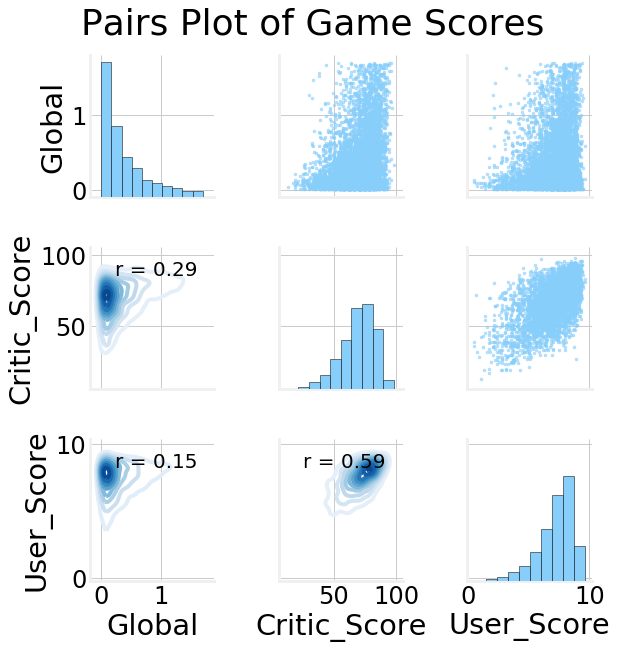

In [120]:
# Extract the columns to  plot
plot_data = features[["Global", "Critic_Score", "User_Score"]]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
    
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = "lightskyblue", alpha = 0.6, marker=".")

# Diagonal is a histogram
grid.map_diag(plt.hist, color = "lightskyblue", edgecolor="black")

# Bottom is correlation and density plot
grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot, cmap = plt.cm.Blues)

# Title for entire plot
plt.suptitle("Pairs Plot of Game Scores", size = 36, y = 1.02);

In [121]:
features.shape

(6136, 1538)

There are 39 features (1 is target) in the dataset after feature engineering and selection.

Splitting data into train and test sets.

In [122]:
from sklearn.model_selection import train_test_split
target = pd.Series(features["Global"])
features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(4908, 1537)
(1228, 1537)
(4908,)
(1228,)


Defining a function to evaluate my model. I will use mean squared error. 

In [124]:
def mse(y_true, y_pred):
    return np.average(pow(y_true - y_pred, 2))

For the baseline guess I'll use median value of global sales in the train dataset.

In [125]:
baseline_guess = np.median(target_train)
baseline_mse = mse(target_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MSE = {:.04f}".format(baseline_mse))

Baseline guess for global sales is: 0.24
Baseline Performance on the test set: MSE = 0.1959


I will compare several simple models with different types of regression, and then focus on the best one for hyperparameter tuning. 

In [126]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

This is a universal function for training a model and evaluating its performance on test data.

In [127]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions and evalute
    model_pred = model.predict(features_test)
    model_mse = mse(target_test, model_pred)
    
    # Return the performance metric
    return model_mse

In [128]:
lr = LinearRegression()
lr_mse = fit_and_evaluate(lr)

print("Linear Regression Performance on the test set: MSE = {:.04f}".format(lr_mse))

Linear Regression Performance on the test set: MSE = 7647388219046523.0000


In [129]:
svm = SVR(C = 1000, gamma=0.1)
svm_mse = fit_and_evaluate(svm)

print("Support Vector Machine Regression Performance on the test set: MSE = {:.04f}".format(svm_mse))

Support Vector Machine Regression Performance on the test set: MSE = 0.1285


In [130]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mse = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set: MSE = {:.04f}".format(random_forest_mse))

C:\Dev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MSE = 0.1147


In [131]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mse = fit_and_evaluate(gradient_boosted)

print("Gradient Boosted Regression Performance on the test set: MSE = {:.04f}".format(gradient_boosted_mse))

Gradient Boosted Regression Performance on the test set: MSE = 0.1215


In [132]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mse = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set: MSE = {:.04f}".format(knn_mse))

K-Nearest Neighbors Regression Performance on the test set: MSE = 0.1402


In [133]:
ridge = Ridge(alpha=10)
ridge_mse = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set: MSE = {:.04f}".format(ridge_mse))

Ridge Regression Performance on the test set: MSE = 0.1213


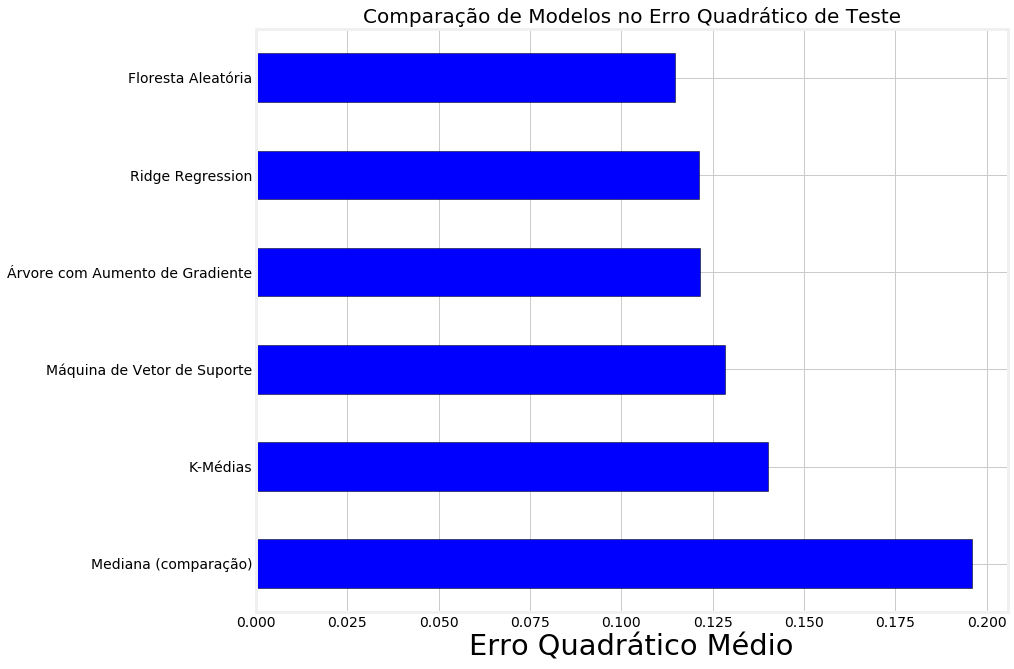

In [149]:
model_comparison = pd.DataFrame({"model": ["Máquina de Vetor de Suporte",
                                           "Floresta Aleatória", "Árvore com Aumento de Gradiente",
                                            "K-Médias", "Mediana (comparação)", "Ridge Regression"],
                                 "mse": [svm_mse, random_forest_mse, 
                                         gradient_boosted_mse, knn_mse, baseline_mse, ridge_mse]})
model_comparison.sort_values("mse", ascending=False).plot(x="model", y="mse", kind="barh",
                                                           color="blue", edgecolor="black",
                                                           legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Erro Quadrático Médio"); plt.xticks(size=14)
plt.title("Comparação de Modelos no Erro Quadrático de Teste", size=20);
plt.savefig(r"C:\Users\1765 IRON\My Tresors\Henrique's tresor\Cursos\Big Data - FIA\big-data-tcc\graf_erromodelos.png")


Gradient boosted regressor seems to be the best model, I will focus on this one.  
  
  First I am going to use randomized search to find the best parameters, and then I will use grid search for optimizing n_estimators. 

In [140]:
# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"max_depth": max_depth,
                       "min_samples_leaf": min_samples_leaf,
                       "min_samples_split": min_samples_split,
                       "max_features": max_features}

In [141]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_squared_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)

In [142]:
random_cv.fit(features_train, target_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.6s finished
C:\Dev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

Printing out 10 best estimators found by randomized search.

In [143]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values("mean_test_score", ascending=False)
random_results.head(10)[["mean_test_score", "param_loss",
                         "param_max_depth", "param_min_samples_leaf", "param_min_samples_split",
                         "param_max_features"]]

KeyError: "['param_loss'] not in index"

In [144]:
random_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Using grid search to find optimal value of the n_estimators parameter.

In [150]:
from sklearn.model_selection import GridSearchCV
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]}

model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_squared_error", verbose=1,
                           n_jobs=-1, return_train_score=True)

In [151]:
grid_search.fit(features_train, target_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  9.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

Now I want to see how the number of trees effects the performance. 

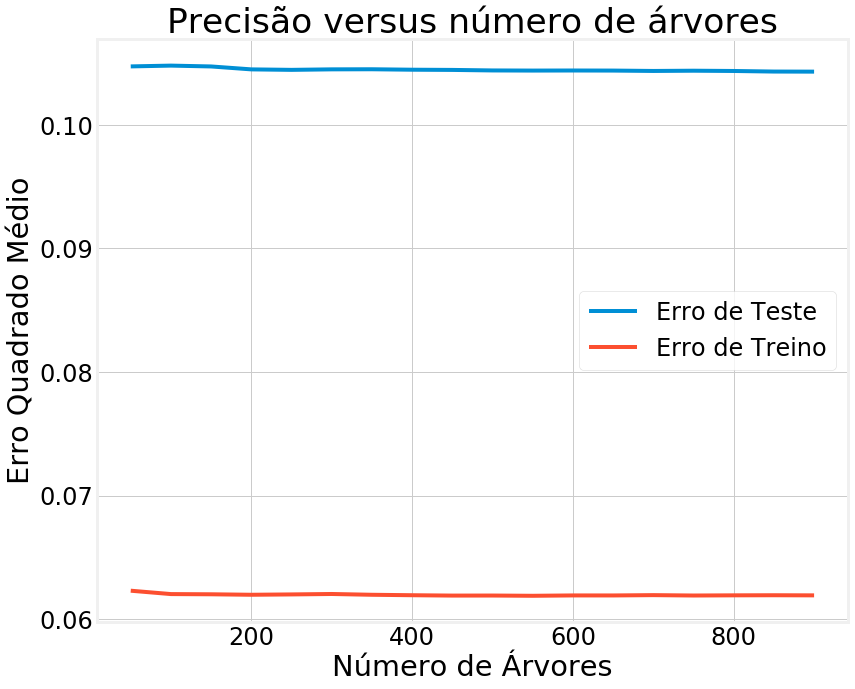

In [161]:
results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Erro de Teste")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Erro de Treino")
plt.xlabel("Número de Árvores"); plt.ylabel("Erro Quadrado Médio"); plt.legend();
plt.title("Precisão versus número de árvores");

The graph shows that the model is overfitting. Training error keeps decreasing, while test error stays almost the same. It means that the model learns training examples very well, but cannot generalize on new, unknown data. This is not a very good model, but I will leave it as is, and try to battle overfitting in the advanced model using imputing, feature selection and feature engineering.

Let's lock the final model and see how it performs on test data.

In [155]:
final_model = grid_search.best_estimator_
final_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [158]:
final_pred = final_model.predict(features_test)
print("Final model performance on the test set: MSE = {:.04f}.".format(mse(target_test, final_pred)))

Final model performance on the test set: MSE = 0.1125.


MAE dropped, but by a very small margin. Looks like hyperparameter tuning didn't really improve the model. I hope advanced model will have a better performance.

To finish with the basic model I am going to draw 2 graphs. First one is comparison of densities of train values, test values and predictions.

C:\Dev\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


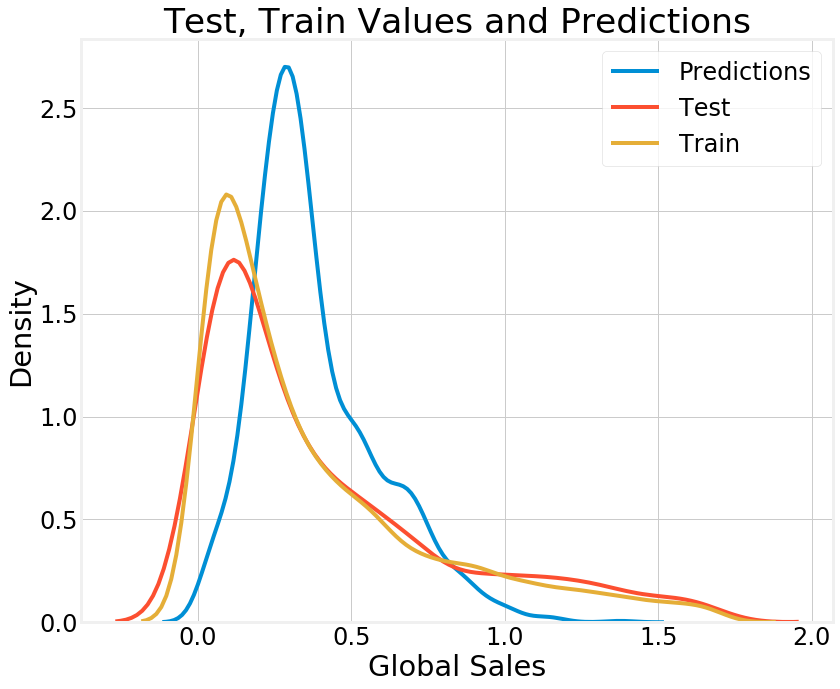

In [159]:
sns.kdeplot(final_pred, label = "Predictions")
sns.kdeplot(target_test, label = "Test")
sns.kdeplot(target_train, label = "Train")

plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");

Predictions density is moved a little to the right, comparing to densities of initial values. The tail is also different. This might help tuning the model in the future. 

Second graph is a histogram of residuals - differences between real values and predictions. 

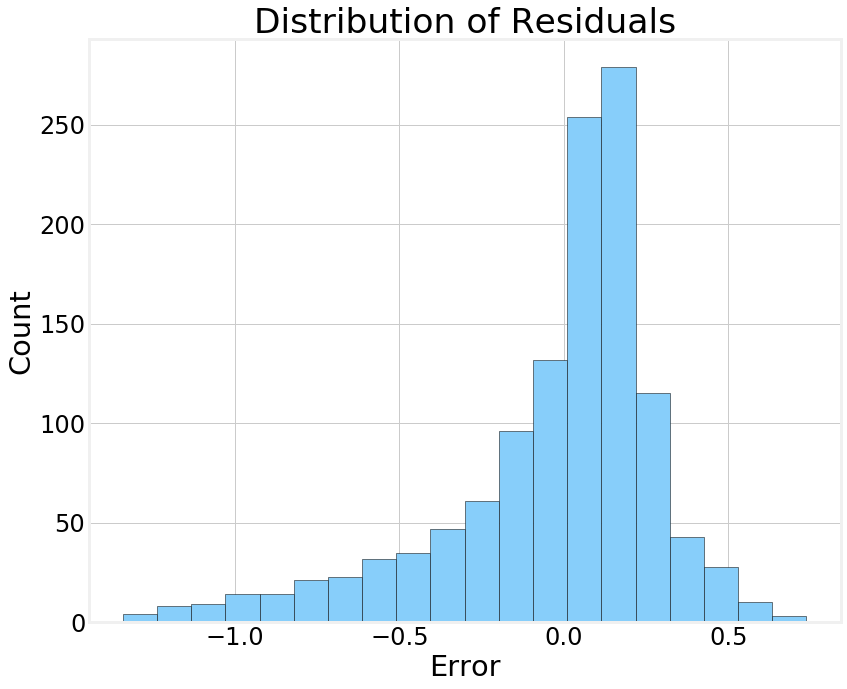

In [160]:
residuals = final_pred - target_test

plt.hist(residuals, color = "lightskyblue", bins = 20,
         edgecolor = "black")
plt.xlabel("Error"); plt.ylabel("Count")
plt.title("Distribution of Residuals");

## Advanced model

In [49]:
def donut_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

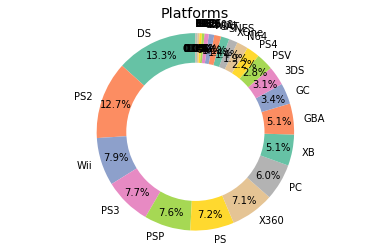

In [50]:
donut_chart(data["Platform"])
plt.title("Platforms")
plt.axis("equal");

In [101]:
data["Platform"].unique()

array(['Wii', 'PS2', 'PS3', 'PS', 'N64', 'GBA', 'DS', 'GC', 'X360', 'GB',
       'PC', '3DS', 'PSP', 'XB', 'NES', 'PS4', 'GEN', '2600', 'SNES',
       'XOne', 'WiiU', 'PSV', 'SCD', 'DC', 'SAT', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [52]:
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [53]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

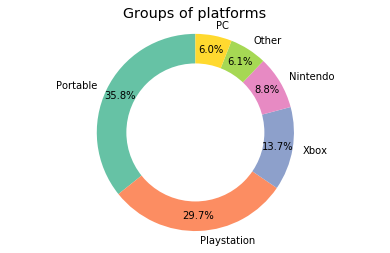

In [54]:
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
donut_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");

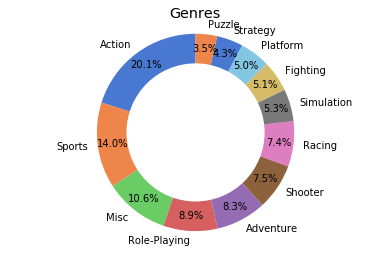

In [55]:
donut_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal");

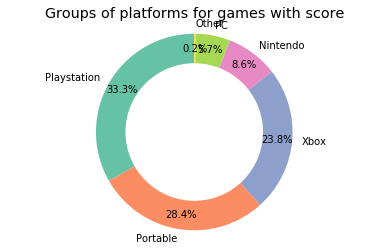

In [56]:
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, platforms))
donut_chart(scored["Grouped_Platform"])
plt.title("Groups of platforms for games with score")
plt.axis("equal");

In [57]:
scored[scored["Grouped_Platform"]=="Other"]

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age,Has_Score,Country,Grouped_Platform
1712,Shenmue,DC,1999,Adventure,Sega,0.52,0.24,0.38,0.04,1.18,88.0,9.0,9.4,201.0,Sega AM2,T,19,True,NA,Other
1877,NFL 2K1,DC,2000,Sports,Sega,1.02,0.05,0.00,0.02,1.09,97.0,22.0,6.0,47.0,Visual Concepts,E,18,True,NA,Other
3815,Seaman,DC,1999,Simulation,Sega,0.00,0.00,0.52,0.00,0.52,82.0,24.0,8.4,16.0,Vivarium,T,19,True,JP,Other
5350,SoulCalibur,DC,1999,Fighting,Namco Bandai Games,0.00,0.00,0.34,0.00,0.34,98.0,24.0,8.8,200.0,Namco,T,19,True,JP,Other
7231,Capcom vs. SNK,DC,2000,Fighting,Virgin Interactive,0.00,0.00,0.22,0.00,0.22,80.0,17.0,9.0,24.0,Capcom,T,18,True,JP,Other
7521,Phantasy Star Online,DC,2000,Role-Playing,Sega,0.00,0.00,0.20,0.00,0.20,89.0,21.0,9.1,33.0,Sonic Team,T,18,True,JP,Other
7643,Grandia II,DC,2000,Role-Playing,Ubisoft,0.00,0.00,0.20,0.00,0.20,90.0,17.0,8.8,57.0,Game Arts,T,18,True,JP,Other
7978,Phantasy Star Online Ver. 2,DC,2001,Role-Playing,Sega,0.00,0.00,0.19,0.00,0.19,80.0,10.0,8.9,18.0,Sonic Team,T,17,True,JP,Other
8905,Shenmue II,DC,2001,Adventure,Sega,0.00,0.00,0.15,0.00,0.15,88.0,9.0,9.4,201.0,Sega AM2,T,17,True,JP,Other
9559,Sega GT,DC,2000,Racing,Sega,0.00,0.00,0.13,0.00,0.13,84.0,25.0,7.7,11.0,TOSE,E,18,True,JP,Other


In [58]:
devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Critic_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Critic_Score"].mean().values})
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100
n_groups = 5
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

In [ ]:
pal = sns.color_palette("RdYlGn", n_groups)
g = sns.JointGrid(x="top%", y="mean_score", data=devs, size=12)
legend_elements = []
for k in range(0, n_groups):
    g.ax_joint.scatter(devs[devs["top_group"]==k+1]["top%"], 
                       devs[devs["top_group"]==k+1]["mean_score"],
                       color=pal[k], alpha=.9, edgecolor="black")
    legend_elements.append(Line2D([0], [0], label=k+1, marker="o", ls="", 
                                  mfc=pal[k], mec=pal[k], alpha=.9, markersize=15))
    g.ax_marg_x.bar(np.arange(k * 100 / n_groups, (k+1) * 100 / n_groups), 
                    devs[devs["top_group"]==k+1].shape[0], 
                    width=1, align="edge", color=pal[k], alpha=.9)
g.ax_marg_y.hist(devs["mean_score"], color=pal[-1], alpha=.9,
                 orientation="horizontal", bins=25, edgecolor="white")
g.set_axis_labels("Top %", "Mean Critic Score")
g.ax_joint.tick_params(labelsize=15)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)
#g.ax_joint.legend(handles=legend_elements, title="Top Group", loc=4)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Developers");

In [ ]:
scored = scored.join(devs.set_index("dev")["top_group"], on="Developer")
scored = scored.rename(columns={"top_group": "Developer_Rank"})

In [ ]:
scored = scored.rename(columns={"top_group": "Developer_Rank"})

In [ ]:
scored["diff"] = (scored["User_Score"] * 10 - scored["Critic_Score"]) / scored["Critic_Score"]
scored["weighted_score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])
plt.hist(scored["diff"], bins=60, edgecolor="black", color="lightskyblue");